In [2]:

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import pandas as pd


def seq2onehot(seq):     #convert the cRBS sequences to one-hot encoding
    module = np.array([[[1,0,0,0]],
                       [[0,1,0,0]],
                       [[0,0,1,0]],
                       [[0,0,0,1]]])
    i = 0
    cRBS_onehot = []
    for i in seq:
        tmp = []
        for item in i:
            if item == 't' or item == 'T':
                tmp.append(module[0])
            elif item == 'c' or item == 'C':
                tmp.append(module[1])
            elif item == 'g' or item == 'G':
                tmp.append(module[2])
            elif item == 'a' or item == 'A':
                tmp.append(module[3])
            else:
                tmp.append([[0,0,0,0]])
        cRBS_onehot.append(tmp)
    cRBS_onehot=np.array(cRBS_onehot).astype('float32')
    return cRBS_onehot


2023-11-30 23:11:06.015087: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-30 23:11:06.070104: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-30 23:11:06.085713: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-30 23:11:06.338191: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

In [3]:

# x_train=np.load("data/c.v 0.8_p.npy",allow_pickle=True)
x_train=pd.read_excel('data/promoter_w_20799.xlsx',header=None).to_numpy().reshape(-1)
x_train=seq2onehot(x_train)
# y_train=np.array(list(map(float,np.load("data/c.v 0.8_s.npy",allow_pickle=True))))
y_train=pd.read_excel('data/fluorescence_w_20799.xlsx',header=None).to_numpy().reshape(-1)
# y_train_new=np.zeros((len(y_train),))
# i=0
# while i < len(y_train):
#     y_train_new[i]=float(y_train[i])
#     i=i+1
# y_train=np.log2(y_train_new)
# y_train 归一化
y_train = np.maximum(y_train, 1e-7)

# Apply log10 transformation
y_train = np.exp(y_train)


/tmp/ipykernel_115755/3962096465.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train)


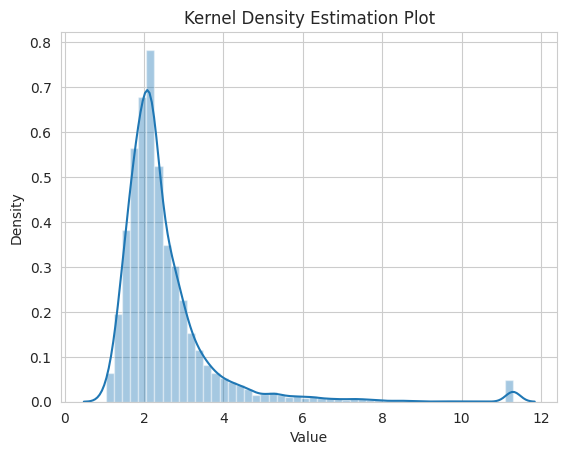

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
sns.distplot(y_train)
plt.title('Kernel Density Estimation Plot')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()
# 绘制直方图


In [5]:
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from keras.layers.core import Activation
from keras.layers import LeakyReLU,BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers.legacy import SGD
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Average
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

# optimizer = SGD(lr=0.001, decay=1e-6)
# model = Sequential()

# model.add(
#         #(6,1,4)
#         Conv2D(100, (6, 1),
#         padding='same',
#         input_shape=(29, 1, 4))
#         )
# model.add(LeakyReLU(alpha=0.1))
# model.add(MaxPooling2D(pool_size=(2, 1)))
# model.add(Conv2D(200, (5, 1),padding='same'))
# model.add(LeakyReLU(alpha=0.1))
# model.add(Conv2D(200, (5, 1),padding='same'))
# model.add(LeakyReLU(alpha=0.1))
# model.add(MaxPooling2D(pool_size=(2, 1)))
# model.add(Flatten())
# model.add(Dense(1024))
# model.add(LeakyReLU(alpha=0.1))
# model.add(Dropout(0.3))
# model.add(Dense(1))
tensorboard_callback = TensorBoard(log_dir="./logs", histogram_freq=1, write_graph=True, write_images=True)

def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv2D(100,  (6,1), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2,1)))
    model.add(Conv2D(200, (5,1), activation='relu'))
    model.add(MaxPooling2D((2,1)))
    model.add(Flatten())
    # model.add(Dense(128, activation='relu'))
    # model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='linear'))  # 输出层，使用线性激活函数
    return model
input_layer = Input(shape=(29, 1, 4))
num_models = 2
cnn_models = [create_cnn_model((29, 1, 4))(input_layer) for _ in range(num_models)]
merged = Average()(cnn_models)

2023-11-30 23:11:07.601157: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-30 23:11:07.614314: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-30 23:11:07.614404: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-30 23:11:07.614717: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

In [6]:

X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, random_state=42)
ensemble_model = Model(inputs=input_layer, outputs=merged)
ensemble_model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mae'])
ensemble_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 29, 1, 4)]   0           []                               
                                                                                                  
 sequential (Sequential)        (None, 1)            156077      ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 1)            156077      ['input_1[0][0]']                
                                                                                                  
 average (Average)              (None, 1)            0           ['sequential[0][0]',             
                                                                  'sequential_1[0][0]']       

In [38]:
# ensemble_model= load_model("weight/weight_MSE_w_20799_normalization100.h5")

In [39]:
history = ensemble_model.fit(X_train,y_train,epochs=1000,batch_size=256,callbacks=[tensorboard_callback])

Epoch 1/1000


74/74 [==============================] - 1s 5ms/step - loss: 2.1121 - mae: 0.8973
Epoch 2/1000
74/74 [==============================] - 0s 4ms/step - loss: 1.7753 - mae: 0.7963
Epoch 3/1000
74/74 [==============================] - 0s 5ms/step - loss: 1.7571 - mae: 0.7913
Epoch 4/1000
74/74 [==============================] - 0s 5ms/step - loss: 1.7181 - mae: 0.7804
Epoch 5/1000
74/74 [==============================] - 0s 4ms/step - loss: 1.6751 - mae: 0.7749
Epoch 6/1000
74/74 [==============================] - 0s 4ms/step - loss: 1.6251 - mae: 0.7652
Epoch 7/1000
74/74 [==============================] - 0s 4ms/step - loss: 1.5941 - mae: 0.7535
Epoch 8/1000
74/74 [==============================] - 0s 6ms/step - loss: 1.5917 - mae: 0.7564
Epoch 9/1000
74/74 [==============================] - 0s 4ms/step - loss: 1.5532 - mae: 0.7430
Epoch 10/1000
74/74 [==============================] - 0s 5ms/step - loss: 1.5427 - mae: 0.7395
Epoch 11/1000
74/74 [==============================] - 0s 6ms/

In [40]:
ensemble_model.save('./weight/weight_MSE_w_20799_normalization100.h5')
# ensemble_model= load_model("weight/weight_MSE_w_20799_GFP.h5")

In [41]:
# import matplotlib.pyplot as plt

# train_loss = history.history['loss']  # 训练损失
# val_loss =history.history['val_loss']  # 验证损失
# epochs = range(1, len(train_loss) + 1)  # 训练轮数

# # 创建一个新的图形
# plt.figure(figsize=(10, 6))

# # 绘制训练损失曲线
# plt.plot(epochs, train_loss, label='训练损失', linestyle='-')

# # 绘制验证损失曲线
# plt.plot(epochs, val_loss, label='验证损失', linestyle='-')

# # 添加标签和图例
# plt.xlabel('训练轮数')
# plt.ylabel('损失')
# plt.legend()

# # 显示图形
# plt.show()

In [8]:
ensemble_model= load_model("weight/weight_MSE_w_20799_normalization100.h5")

7/7 [==============================] - 0s 943us/step


mse-test 0.42892211592463103


/home/fengrenxu/.conda/envs/tensorflow_base/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26679 (\N{CJK UNIFIED IDEOGRAPH-6837}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/fengrenxu/.conda/envs/tensorflow_base/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/fengrenxu/.conda/envs/tensorflow_base/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 32034 (\N{CJK UNIFIED IDEOGRAPH-7D22}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/fengrenxu/.conda/envs/tensorflow_base/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24341 (\N{CJK UNIFIED IDEOGRAPH-5F15}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/fengrenxu/.conda/envs/tensorflow_base/lib/python3.8/site-packages/IPyt

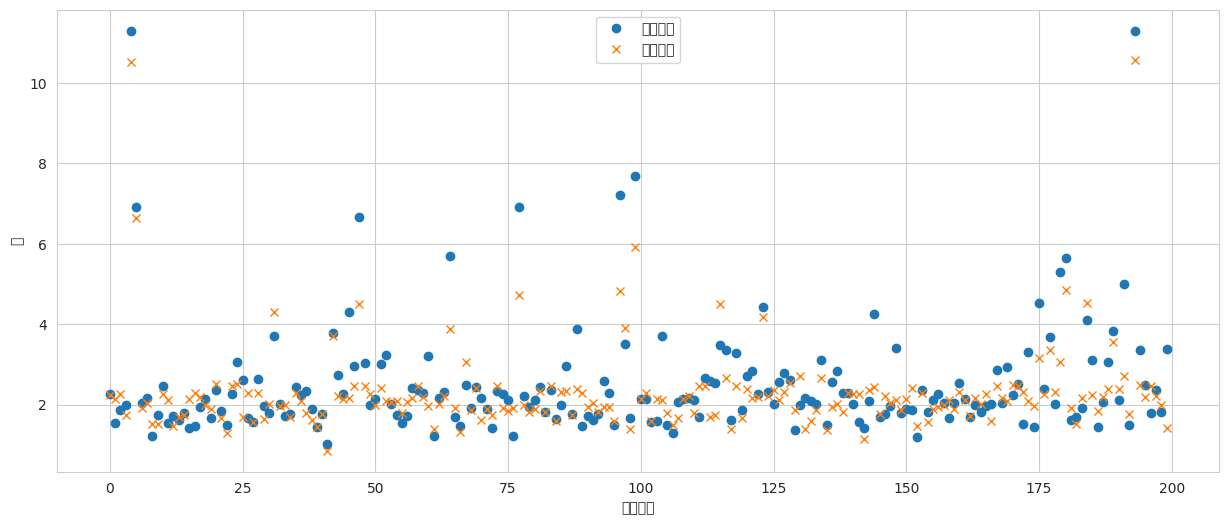

In [16]:
import matplotlib.pyplot as plt

# 使用模型进行预测

y_pred =ensemble_model.predict(X_train[:200])

# 将预测值和真实值提取出来
y_pred = y_pred.flatten()  # 将预测值展平成一维数组
y_true = y_train[:200] # 真实值
mse = np.mean((y_pred - y_true) ** 2)
# 创建一个新的图形
plt.figure(figsize=(15, 6))

print('mse-test', mse)
# 绘制真实数据的点
plt.plot(y_true, label='真实数据', marker='o', linestyle='None')

# 绘制模型的预测数据的点
plt.plot(y_pred, label='模型预测', marker='x',linestyle='None')

# 添加标签和图例
plt.xlabel('样本索引')
plt.ylabel('值')
plt.legend()

# 显示图形
plt.show()

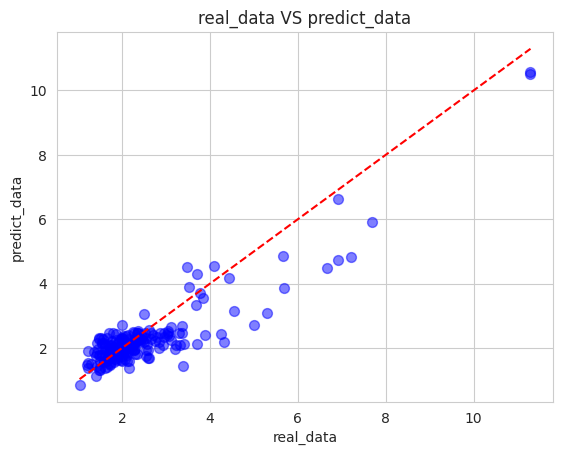

In [22]:
# 绘制散点图
plt.scatter(y_true, y_pred, color='blue', s=50, alpha=0.5)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
plt.xlabel('real_data')
plt.ylabel('predict_data')
plt.title('real_data VS predict_data')
plt.grid(True)

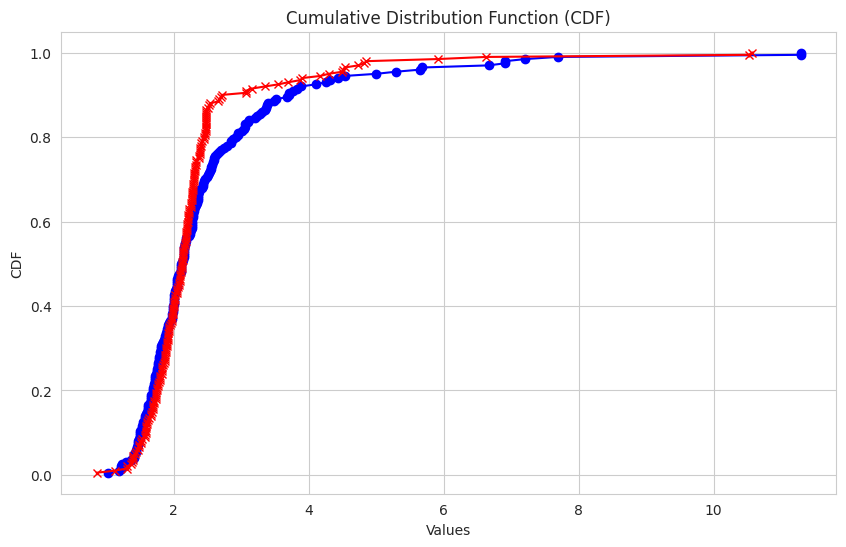

In [23]:
y_true_sorted = np.sort(y_true)
y_pred_sorted = np.sort(y_pred)
cdf_true = np.arange(1, len(y_true_sorted) + 1) / len(y_true_sorted)
cdf_pred = np.arange(1, len(y_pred_sorted) + 1) / len(y_pred_sorted)

# Create a new figure
plt.figure(figsize=(10, 6))

# Plot the CDF of true values
plt.plot(y_true_sorted, cdf_true, label='True Values', marker='o', linestyle='-', color='blue')

# Plot the CDF of predicted values
plt.plot(y_pred_sorted, cdf_pred, label='Predicted Values', marker='x', linestyle='-', color='red')

# Add grid lines
plt.grid(True)

# Add title and labels
plt.title('Cumulative Distribution Function (CDF)')
plt.xlabel('Values')
plt.ylabel('CDF')

# Show the plot
plt.show()